In [2]:
import mysql
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
import cv2 
from io import BytesIO
import os
import glob

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.stats import shapiro, wilcoxon, ttest_ind, mannwhitneyu, pearsonr

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [3]:
torch.manual_seed(1)

In [4]:
# csv -> DataFrame 변환
df = pd.read_csv('movieDF.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901 entries, 0 to 9900
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9901 non-null   int64  
 1   ko_name       9901 non-null   object 
 2   en_name       9744 non-null   object 
 3   year          9900 non-null   float64
 4   country       9901 non-null   object 
 5   grade         9625 non-null   object 
 6   genre         9901 non-null   object 
 7   runtime       9901 non-null   int64  
 8   release_date  9898 non-null   object 
 9   audience      9901 non-null   int64  
 10  director      9885 non-null   object 
 11  story         9897 non-null   object 
 12  poster_link   9901 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 1005.7+ KB


수치형 변수들의 기술 통계량 확인

In [5]:
df.describe()

,id,year,runtime,audience
count,9901.000000,9900.000000,9901.000000,9.901000e+03
mean,31396.784567,2008.044747,105.780325,3.312004e+05
std,20679.489847,11.419085,18.353480,1.087682e+06
min,1.000000,1921.000000,60.000000,1.000000e+03
25%,10789.000000,2001.000000,94.000000,5.418000e+03
50%,31562.000000,2011.000000,104.000000,2.459500e+04
75%,51912.000000,2017.000000,116.000000,1.557980e+05
max,61816.000000,2024.000000,234.000000,1.761375e+07


수치형 변수들의 히스토그램 확인

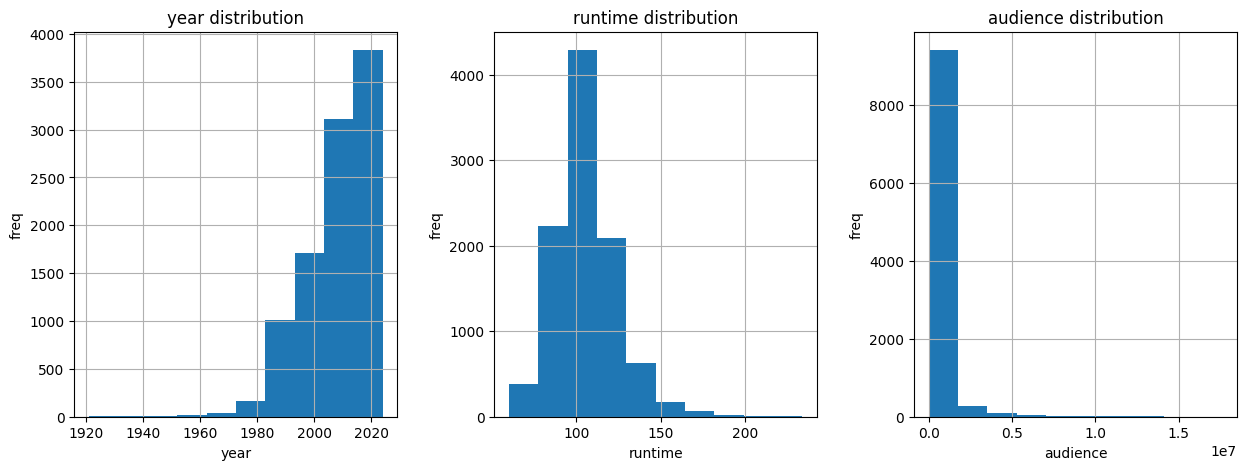

In [6]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
cols = ['year', 'runtime', 'audience']
for idx, col in enumerate(cols):
    df[[col]].hist(ax=axs[idx])
    axs[idx].set_title(f"{col} distribution")
    axs[idx].set_xlabel(col)
    axs[idx].set_ylabel('freq')
plt.show()

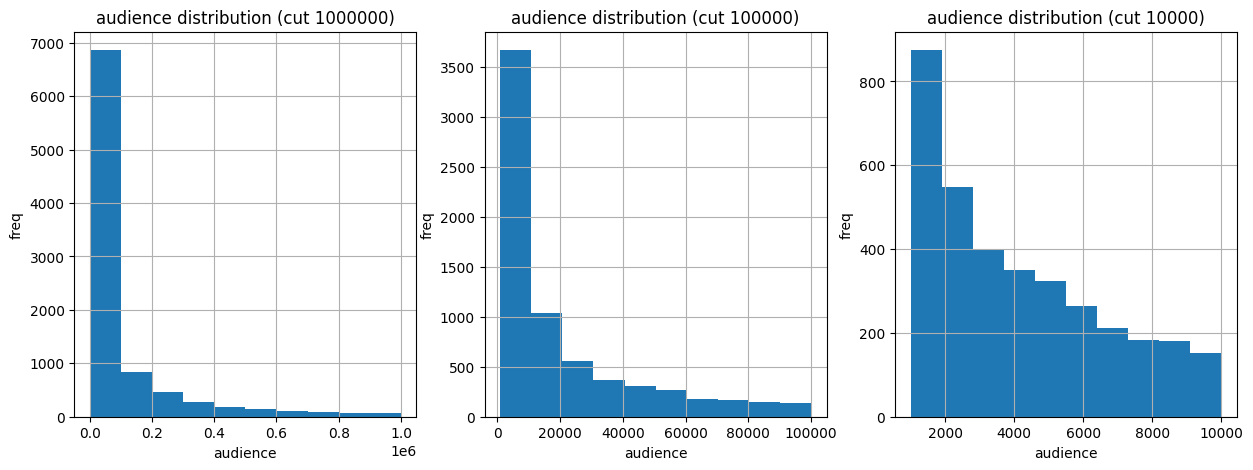

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
values = [1000000, 100000, 10000]
for idx, value in enumerate(values):
    df[df['audience'] < value]['audience'].hist(ax=axs[idx])
    axs[idx].set_title(f"audience distribution (cut {value})")
    axs[idx].set_xlabel('audience')
    axs[idx].set_ylabel('freq')
plt.show()

가설1 : 국내 영화보다 미국 영화의 상영 시간이 더 길 것이다. (독립표본 t검정)  
가설1 근거 : 아바타, 타이타닉 같이 미국 영화가 국내 영화보다 스케일이 큰 경우가 많기 때문에 상영 시간도 더 길 것으로 생각한다.  
  
가설2 : 연도가 증가할수록 영화의 평균 관객 수가 증가했을 것이다. (상관 분석)  
가설2 근거 : 연도가 증가할수록 영화 산업이 발전할 것이고 관객들의 관심도 더 커질 것이기 때문에 평균 관객 수가 증가할 것이다.  
  
가설3 : 국내 영화와 외국 영화의 장르 분포에 차이가 있을 것이다 (카이제곱 검정)  
가설3 근거 : 국내 영화는 대부분 코미디나 드라마 장르가 많지만 미국 영화는 판타지나 어드벤처, SF 등의 스케일이 큰 장르가 많은 것이라 생각한다.  

In [8]:
# 국가 범주 변수 생성
df['country_category'] = df['country'].apply(lambda x : '한국' if '한국' in x else '외국')
df

,id,ko_name,en_name,year,country,grade,genre,runtime,release_date,audience,director,story,poster_link,country_category
0,1,히트,Heat,1995.0,미국,청소년 관람불가,"액션, 범죄, 드라마",171,2017-11-09,412819,마이클 만,LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두 번의 이혼 경력과 순탄치 ...,https://image.cine21.com/resize/cine21/poster/...,외국
1,2,랜섬,Ransom,1996.0,미국,15세이상관람가,"액션, 범죄, 드라마",129,1996-12-07,508244,론 하워드,미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰 멀론은 성공의 상징이며 언...,https://image.cine21.com/resize/cine21/poster/...,외국
2,3,귀여운 여인,Pretty Woman,1990.0,미국,청소년 관람불가,"멜로·로맨스, 코미디",125,1990-09-15,109797,게리 마샬,에드워드는 망해가는 회사를 사들여 나누어서 비싸게 파는 일을 하는 부유하고도 냉정한...,https://image.cine21.com/resize/IMGDB/poster/2...,외국
3,4,라스베가스를 떠나며,Leaving Las Vegas,1995.0,미국,청소년 관람불가,"드라마, 멜로·로맨스",112,1996-03-01,214157,마이크 피기스,사랑이 짧으면 슬픔은 길어진다! 벤은 할리우드에서 유망한 극작가이다. 그의 작품은 ...,https://image.cine21.com/resize/cine21/poster/...,외국
4,5,보디가드,The Bodyguard,1992.0,미국,15세이상관람가,"뮤직, 멜로·로맨스",125,2022-12-07,747238,믹 잭슨,“절대 그녀에게서 눈을 떼지 말 것” “절대 경호를 풀지 말 것” “절대 사랑에 빠...,https://image.cine21.com/resize/cine21/poster/...,외국
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,61787,"하이라이트: 라이츠 고 온, 어게인 인 시네마","HIGHLIGHT: LIGHTS GO ON, AGAIN IN CINEMA",2024.0,한국,전체 관람가,뮤직,116,2024-10-16,6190,오윤동,15년간 변함없이 강렬한 음악과 무대를 선보이며 독보적인 길을 걸어온 하이라이트 1...,https://image.cine21.com/resize/cine21/poster/...,한국
9897,61796,아이브 더 퍼스트 월드투어 인 시네마,IVE THE 1ST WORLD TOUR in CINEMA,2024.0,한국,전체 관람가,뮤직,111,2024-10-16,3010,조윤수,"Dive into IVE! 안녕하세요, IVE입니다! 보석 같은 매력, 독보적인 퍼...",https://image.cine21.com/resize/cine21/poster/...,한국
9898,61797,"괜찮아, 앨리스","Efterskole, Going to the Wonderland Korea",2024.0,한국,전체 관람가,다큐멘터리,74,2024-11-13,1311,양지혜,대다수가 앞만 보고 달려가는 ‘이상한 나라’ 대한민국에서 남들과 다른 길을 선택한 ...,https://image.cine21.com/resize/cine21/poster/...,한국
9899,61804,엘리자벳: 더 뮤지컬 라이브,Elisabeth: The Musical Live,2024.0,한국,12세이상관람가,"뮤직, 뮤지컬",163,2024-10-16,6610,박재석,"“루케니, 도대체 왜? 황후 엘리자벳을 죽였습니까?” “내가 그녀를 암살한 건… 그...",https://image.cine21.com/resize/cine21/poster/...,한국


In [9]:
runtime_ko = df[df['country_category'] == '한국']['runtime']
runtime_fo = df[df['country_category'] == '외국']['runtime']

In [18]:
runtime_ko = df[df['country'] == '한국']['runtime'] # 한국 상영시간
runtime_fo = df[df['country'] == '미국']['runtime'] # 미국 상영시간

# 정규성 검정 - 한국 영화
stat_ko, p_ko = shapiro(runtime_ko)
stat_fo, p_fo = shapiro(runtime_fo)
print(f"검정통계량 : {stat_ko:.4f}, 유의확률 : {p_ko:.4f}")
print(f"검정통계량 : {stat_fo:.4f}, 유의확률 : {p_fo:.4f}")

검정통계량 : 0.9872, 유의확률 : 0.0000
검정통계량 : 0.9195, 유의확률 : 0.0000


In [118]:
# 독립표본 t-검정
statistic, p_value = ttest_ind(runtime_ko, runtime_fo, alternative='less')
print(statistic, p_value)

# Mann-Whitney U 검정 (단측 검정)
statistic, p_value = mannwhitneyu(runtime_ko, runtime_fo, alternative='less')
print(statistic, p_value)

-9.580888099431785 6.961916011685133e-22
3740417.0 4.3942369560282396e-11


검정 결과 유의확률이 매우 작아 유의수준 0.05 하에서 귀무가설을 기각한다. 즉, 한국 영화의 상영 시간이 외국 영화보다 더 짧다.

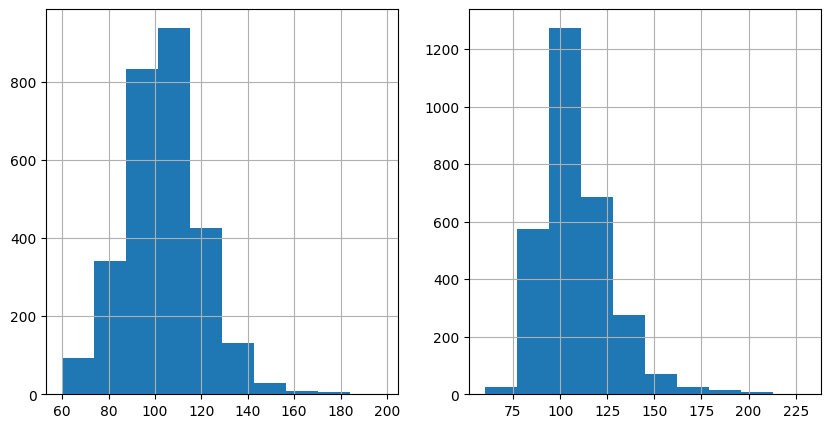

In [119]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

runtime_ko.hist(ax=axs[0])
runtime_fo.hist(ax=axs[1])

plt.show()

In [124]:
runtime_ko.mean(), runtime_fo.mean()

(103.78851640513552, 108.25)

In [162]:
group = df.groupby('year')['audience'].mean()
year = group.index
audience = group.values

correlation, p_value = pearsonr(year, audience)
print(correlation, p_value)

0.6086557893278572 2.1047353246887055e-09


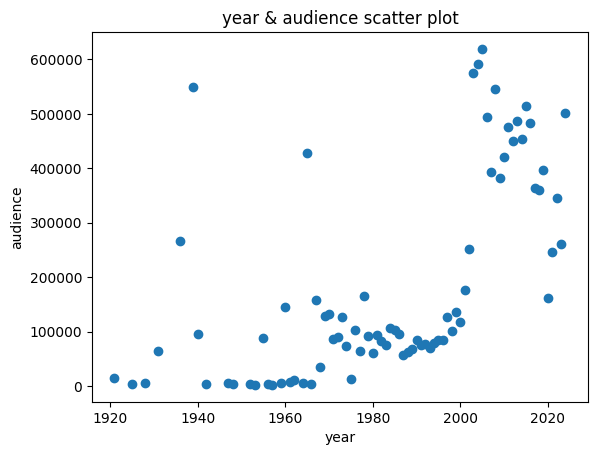

In [170]:
plt.scatter(year, audience)
plt.title('year & audience scatter plot')
plt.xlabel('year')
plt.ylabel('audience')
plt.show()

이상치를 제거하면 다항 회귀를 할 수 있을 것으로 판단

In [172]:
groupDF = pd.DataFrame({
    'year' : year,
    'audience' : audience
})

groupDF

,year,audience
0,1921.00,14425.00
1,1925.00,2928.00
2,1928.00,4946.00
3,1931.00,63638.00
4,1936.00,266054.00
...,...,...
75,2020.00,160806.13
76,2021.00,246238.78
77,2022.00,346019.69
78,2023.00,260045.52


In [177]:
outlierDF = groupDF[(groupDF['year'] < 1980) & (groupDF['audience'] > 200000)]
outlierDF

,year,audience
4,1936.00,266054.00
5,1939.00,549131.00
20,1965.00,427725.50


In [181]:
outlier_index = outlierDF.index
groupDF2 = groupDF.drop(outlier_index)

groupDF2.corr() # 상관계수가 더 올라갔다

,year,audience
year,1.00,0.73
audience,0.73,1.00


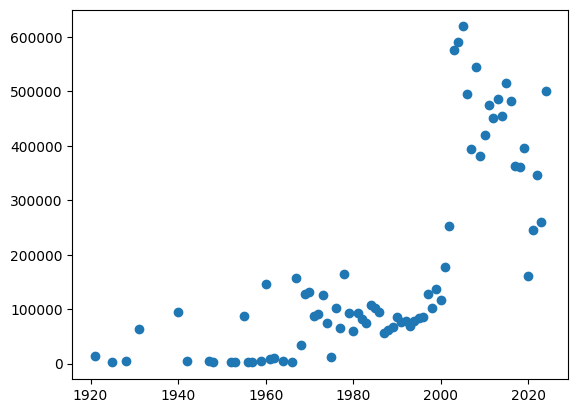

In [183]:
plt.scatter(groupDF2['year'], groupDF2['audience'])
plt.show()

In [211]:
X = groupDF2[['year']] # DF 형태
y = groupDF2['audience'] # Series 형태

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2,
                                                    random_state=42)
print(f"X_train.shape : {X_train.shape}")
print(f"X_test.shape : {X_test.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")

X_train.shape : (61, 3)
X_test.shape : (16, 3)
y_train.shape : (61,)
y_test.shape : (16,)


In [212]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_train.values, y_pred_train))
print(r2_score(y_test, y_pred_test))

0.6134083150426661
0.6917239762922618


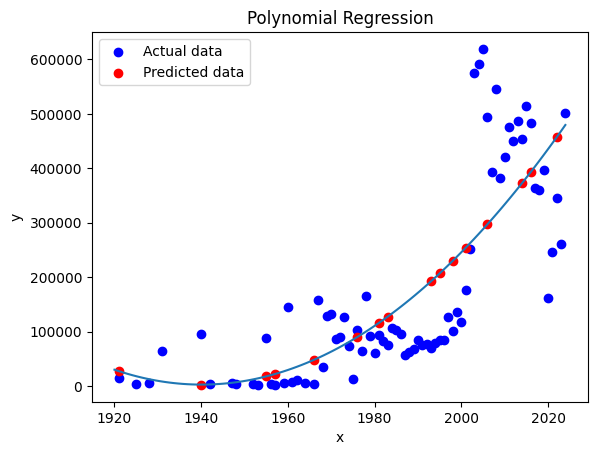

In [246]:
linspaceDF = pd.DataFrame({'year' : np.linspace(1920, 2024, 100)})
linspace_pred = model.predict(poly.transform(linspaceDF))

# 결과 시각화
plt.scatter(X, y, color='blue', label='Actual data')
plt.scatter(X_test[:, 1], y_pred_test, color='red', label='Predicted data')
plt.plot(linspaceDF, linspace_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression')
plt.legend()
plt.show()